# Experiment 3: Hyperparameter tuning impacts on Energy vs. Performance

Conditions: 
{BayesOpt, GridSearch} X {RandForest, XGBoost} X {BinClass, MultiClass, Regression}

Main Dependent vars:
Energy, Power, F1

Others: Power, Accuracy, MeanSquaredError, Precision, Recall, Runtime,

In [126]:
import os
from typing import List
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
sns.set_theme("talk")

sns.__version__

'0.12.1'

In [9]:
def get_tuning_results(folder: str, datasets: List[str]) -> pd.DataFrame:
    rf_results_paths = [ folder + '/combined_results_rf_' + f + '.csv' for f in datasets ]

    xgb_results_paths = [ folder + '/combined_results_xgb_' + f + '.csv' for f in datasets ]
    rf_results = pd.DataFrame()
    for i, f in enumerate(rf_results_paths):
        r = pd.read_csv(f, index_col=0)
        r['dataset'] = DATASETS[i]
        r['model'] = 'rf'
        rf_results = pd.concat([rf_results, r])

    xgb_results = pd.DataFrame()
    for i, f in enumerate(xgb_results_paths):
        r = pd.read_csv(f, index_col=0)
        r['dataset'] = DATASETS[i]
        r['model'] = 'xgb'
        xgb_results = pd.concat([xgb_results, r])

    results = pd.concat([rf_results, xgb_results])
    # put target values in single column regardless of dataset
    y = results.apply(lambda r: r['F1'] if 'f1' in r.Target else r['MSE'], axis=1)
    results['target_val'] = y
    return results

## Hyperparameter Tuning initial experiment (3.1)

In [10]:
# load data
DATASETS = ['bank', 'maternal', 'winequality']
results = get_tuning_results('tuning_runs', DATASETS)
results

,Tuner,Max Depth,Max Features,N Estimators,Accuracy,Precision,Recall,F1,Micro F1,Target,Energy (J),Runtime (ms),Power (W),dataset,model,MSE,MAE,Colsample By Tree,target_val
0,grid,5,0.200000,150,0.848451,0.683525,0.816415,0.717880,0.848451,f1,492.35,1.652625e+10,2.979199e-11,bank,rf,NaN,NaN,NaN,0.717880
1,bayes,5,0.200715,52,0.841814,0.672294,0.794766,0.703863,0.841814,f1,1249.46,2.729963e+10,4.576839e-11,bank,rf,NaN,NaN,NaN,0.703863
0,grid,5,0.200000,100,0.660099,0.642365,0.720545,0.656856,0.660099,f1_macro,279.98,1.290024e+10,2.170347e-11,maternal,rf,NaN,NaN,NaN,0.656856
1,bayes,5,0.200000,150,0.655172,0.637606,0.717835,0.651920,0.655172,f1_macro,1026.84,2.426913e+10,4.231054e-11,maternal,rf,NaN,NaN,NaN,0.651920
0,grid,5,0.500000,50,NaN,NaN,NaN,NaN,NaN,MSE,285.75,1.154594e+10,2.474896e-11,winequality,rf,0.407408,0.510033,NaN,0.407408
1,bayes,5,0.477796,50,NaN,NaN,NaN,NaN,NaN,MSE,2507.20,5.016350e+10,4.998056e-11,winequality,rf,0.407408,0.510033,NaN,0.407408
0,grid,3,NaN,100,0.898230,0.736855,0.647136,0.677283,0.898230,f1,340.08,6.463556e+09,5.261500e-11,bank,xgb,NaN,NaN,0.800000,0.677283
1,bayes,3,NaN,83,0.897124,0.732133,0.646516,0.675657,0.897124,f1,961.73,1.773123e+10,5.423934e-11,bank,xgb,NaN,NaN,0.365836,0.675657
0,grid,5,NaN,100,0.812808,0.773141,0.793504,0.782412,0.812808,f1_macro,264.20,6.417575e+09,4.116820e-11,maternal,xgb,NaN,NaN,0.500000,0.782412
1,bayes,5,NaN,150,0.817734,0.778460,0.796214,0.786434,0.817734,f1_macro,963.33,1.911529e+10,5.039579e-11,maternal,xgb,NaN,NaN,0.622470,0.786434


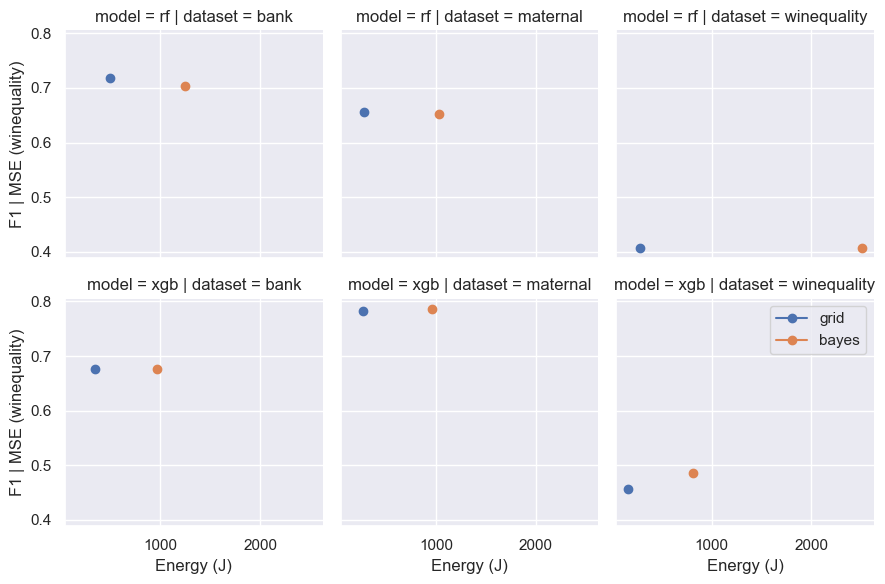

In [11]:
# plot pareto for energy vs. f1 performance
grid = sns.FacetGrid(results, row="model", col="dataset", hue="Tuner")

grid.map(plt.plot, 'Energy (J)', 'target_val', marker="o")
grid.set(ylabel='F1 | MSE (winequality)')
plt.legend()
plt.savefig('figures/tuning_pareto.pdf')

looks like since tuning results are comparable, this isn't really a good way to visualize it.

Getting just energy results

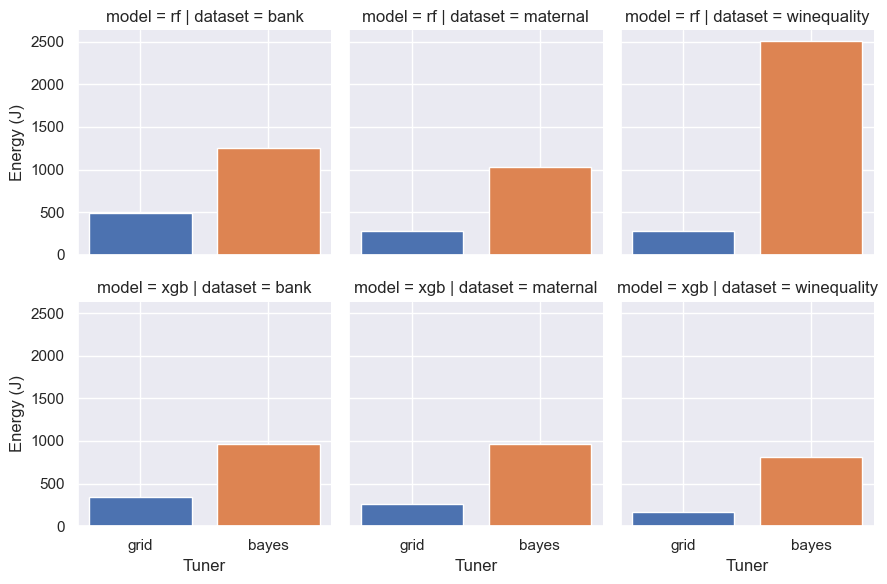

In [12]:
grid = sns.FacetGrid(results, row="model", col="dataset", hue="Tuner")  # hue for salience
grid.map(plt.bar, 'Tuner', 'Energy (J)')
plt.savefig('figures/tuning_energy.pdf')

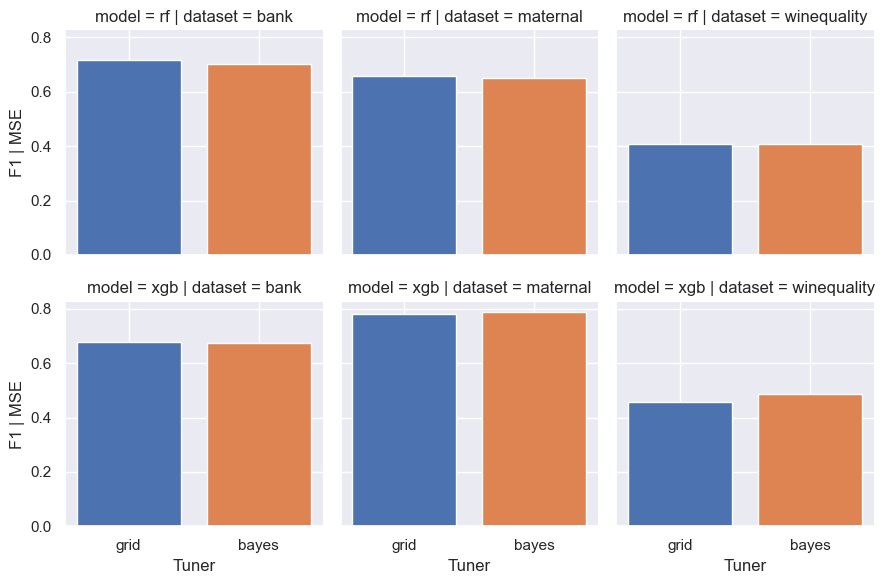

In [13]:
grid = sns.FacetGrid(results, row="model", col="dataset", hue="Tuner")  # hue for salience
grid.map(plt.bar, 'Tuner', 'target_val')
grid.set(ylabel='F1 | MSE')
plt.savefig('figures/tuning_performance.pdf')

In [14]:
# TODO: perhaps plot all bars on the same axes, with different y ticks for 
#       Energy and classification performance measure?
toplot = pd.melt(id_vars=['Tuner', 'model', 'dataset'], )
grid = sns.catplot(results, row="model", col="dataset", x="Tuner", y="Energy (J)", hue="")

TypeError: melt() missing 1 required positional argument: 'frame'

## Hyperparameter tuning with early stopping experiment (3.2)

In [15]:
# load datasets
results = get_tuning_results('bayes_runs', DATASETS)
print(results['N_iter'].dtype)
results

int64


,Tuner,N_iter,Max Depth,Max Features,N Estimators,Accuracy,Precision,Recall,F1,Micro F1,Target,Energy (J),Runtime (ms),Power (W),dataset,model,MSE,MAE,Colsample By Tree,target_val
0,random,1,4,0.558324,93,0.804204,0.652424,0.805046,0.675739,0.804204,f1,79.96,1.917015e+09,4.171069e-11,bank,rf,NaN,NaN,NaN,0.675739
1,random,1,5,0.798055,125,0.827434,0.669062,0.818074,0.699384,0.827434,f1,89.08,2.041568e+09,4.363313e-11,bank,rf,NaN,NaN,NaN,0.699384
2,random,1,3,0.256252,110,0.810841,0.655491,0.804287,0.680801,0.810841,f1,77.70,2.036660e+09,3.815069e-11,bank,rf,NaN,NaN,NaN,0.680801
3,random,1,3,0.407413,89,0.785398,0.640896,0.794500,0.657811,0.785398,f1,76.26,1.945697e+09,3.919418e-11,bank,rf,NaN,NaN,NaN,0.657811
4,random,1,4,0.298864,98,0.813053,0.657035,0.805527,0.683021,0.813053,f1,76.52,1.951749e+09,3.920586e-11,bank,rf,NaN,NaN,NaN,0.683021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,bayes,27,3,NaN,50,NaN,NaN,NaN,NaN,NaN,MSE,658.29,1.477840e+10,4.454407e-11,winequality,xgb,0.485462,0.536710,0.596124,0.485462
267,bayes,27,3,NaN,50,NaN,NaN,NaN,NaN,NaN,MSE,621.42,1.422933e+10,4.367177e-11,winequality,xgb,0.485462,0.536710,0.624519,0.485462
268,bayes,27,3,NaN,50,NaN,NaN,NaN,NaN,NaN,MSE,662.80,1.482882e+10,4.469674e-11,winequality,xgb,0.485462,0.536710,0.594892,0.485462
269,bayes,27,3,NaN,50,NaN,NaN,NaN,NaN,NaN,MSE,622.37,1.402314e+10,4.438163e-11,winequality,xgb,0.485462,0.536710,0.576563,0.485462


### energy as a function of iterations

In [127]:
# for adding visible point for grid search
def addgridpoint(griddata, ax, x_col: str, y_col: str, **kwargs):
    row = griddata.iloc[0]
    s = ax.scatter(row.loc[x_col], row.loc[y_col], marker='D', color='black', s=100)
    return s

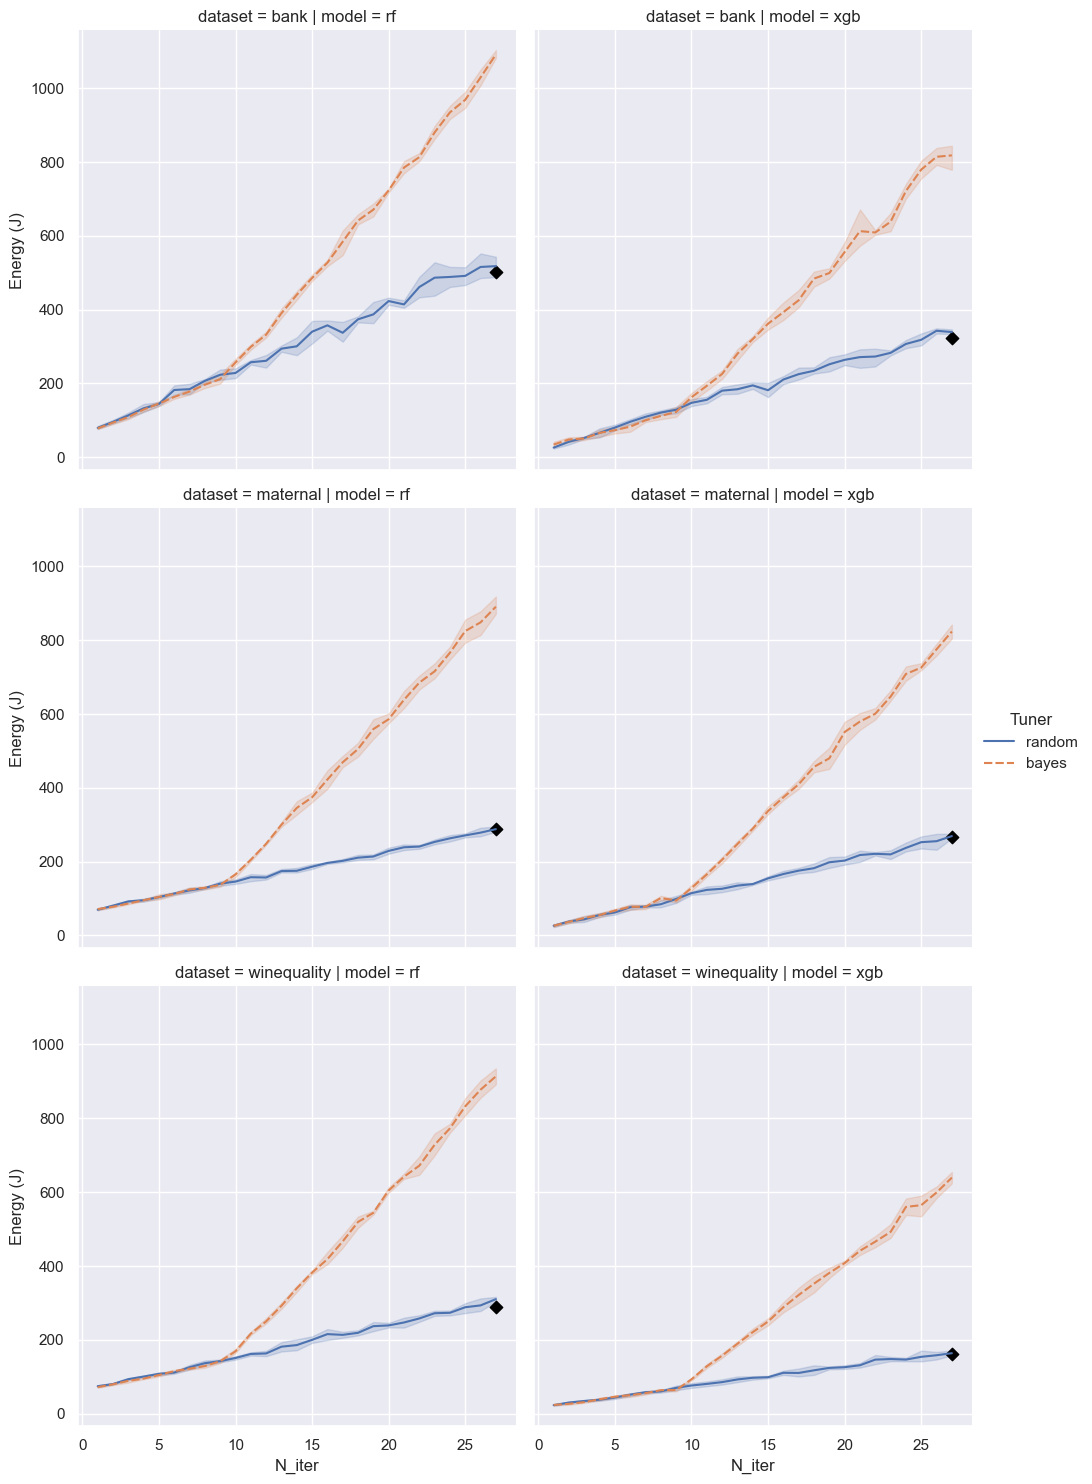

In [17]:
grid = sns.relplot(data=results[results.Tuner != 'grid'], x='N_iter', y='Energy (J)',
                   col="model", row="dataset",
                   hue="Tuner", style="Tuner", kind='line')

gridresults = results.loc[results.Tuner == 'grid'].reset_index(drop=True)

for (dataset, model), ax in grid.axes_dict.items():
    gridpoint = gridresults[(gridresults.model == model) & (gridresults.dataset == dataset)]
    addgridpoint(gridpoint, ax, 'N_iter', 'Energy (J)')

plt.savefig('figures/tuning_iterations_v_energy.pdf')

### performance as function of hyperparam tuning iterations

In [18]:
# in above differences are a little hard to see because of scaled y-axes...
# try separate plots for each dataset
def plot_tuning_perf_v_iter_dataset(dataset: str,
                               allresults: pd.DataFrame) -> sns.axisgrid.FacetGrid:
    data = results[results.dataset == dataset]
    grid = sns.relplot(data=data, x='N_iter', y='target_val', hue='Tuner',
                       style='Tuner', col='model', kind='line')
    grid.set(ylabel=data.Target.iloc[0])
    return grid

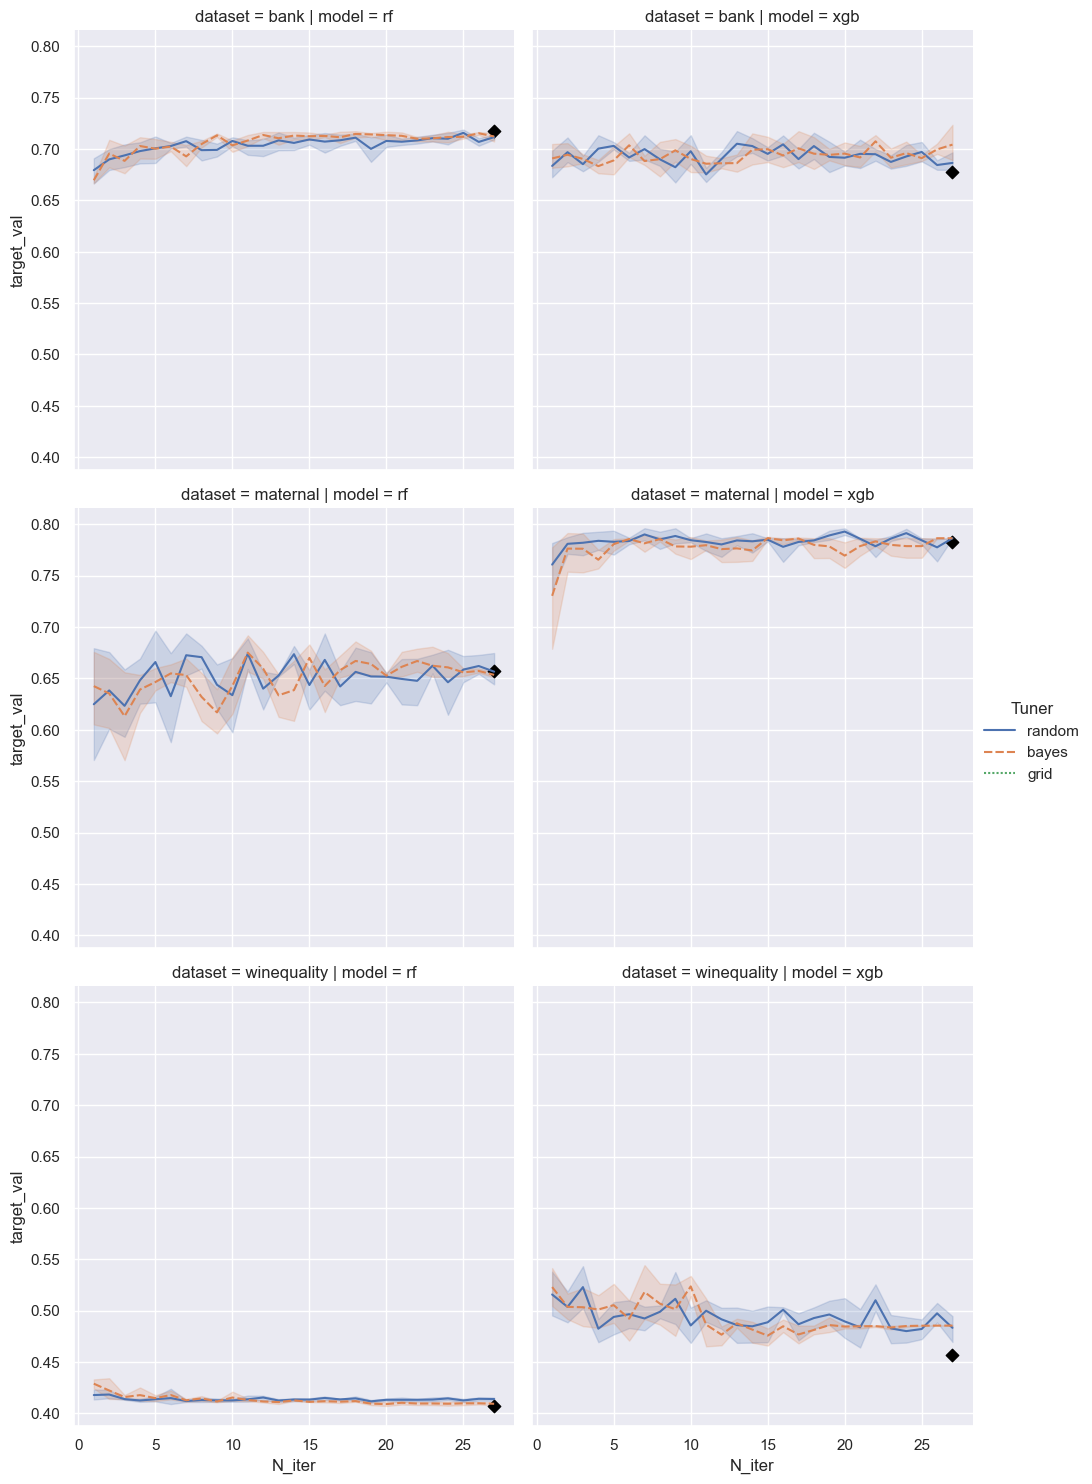

In [19]:
grid = sns.relplot(data=results, x='N_iter', y='target_val', col="model", row="dataset",
                   hue="Tuner", style="Tuner", kind='line')
for (dataset, model), ax in grid.axes_dict.items():
    gridpoint = gridresults[(gridresults.model == model) & (gridresults.dataset == dataset)]
    addgridpoint(gridpoint, ax, 'N_iter', 'target_val')
plt.savefig('figures/tuning_iterations_v_performance.pdf')

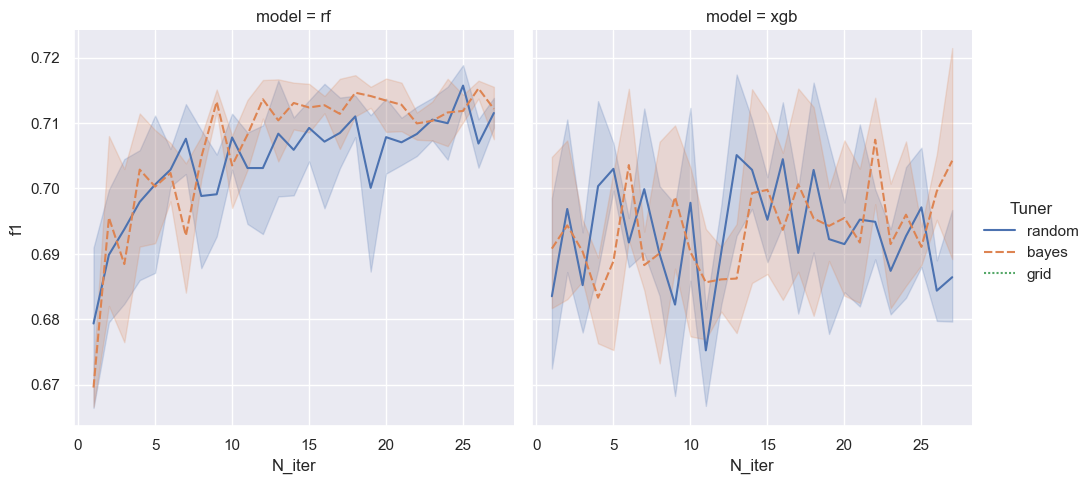

In [20]:
plot_tuning_perf_v_iter_dataset('bank', results)

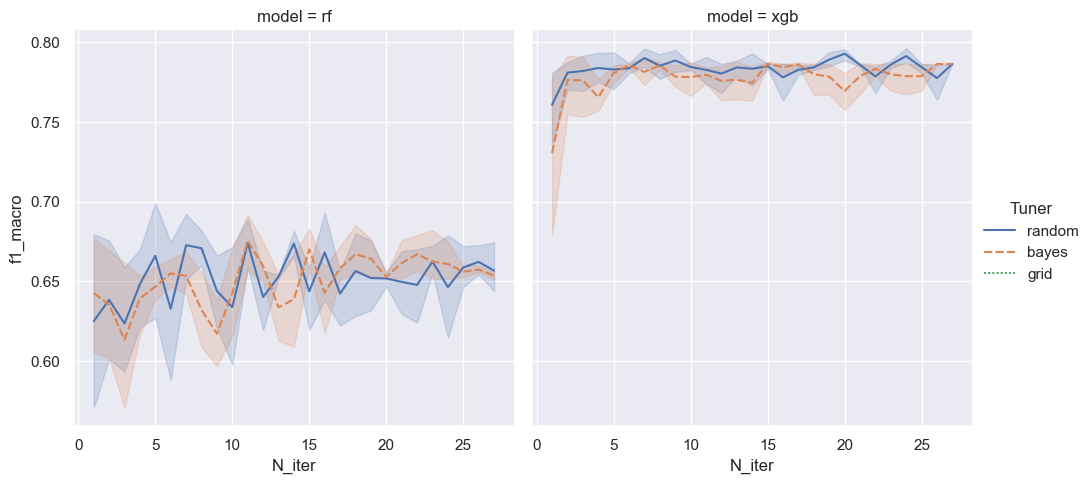

In [21]:
plot_tuning_perf_v_iter_dataset('maternal', results)

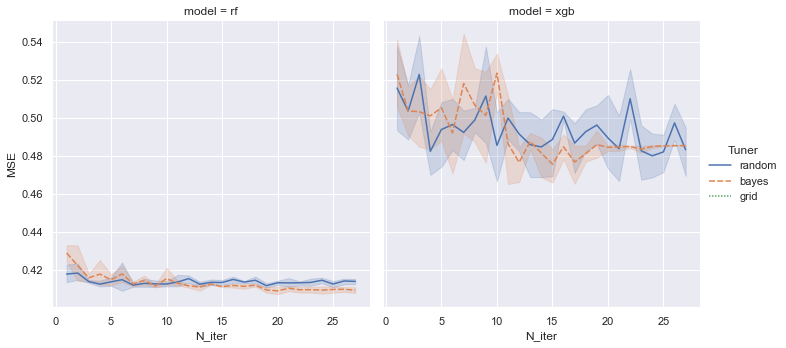

In [35]:
plot_tuning_perf_v_iter_dataset('winequality', results)

### Performance vs. Energy

In [50]:
from matplotlib import markers
import numpy as np

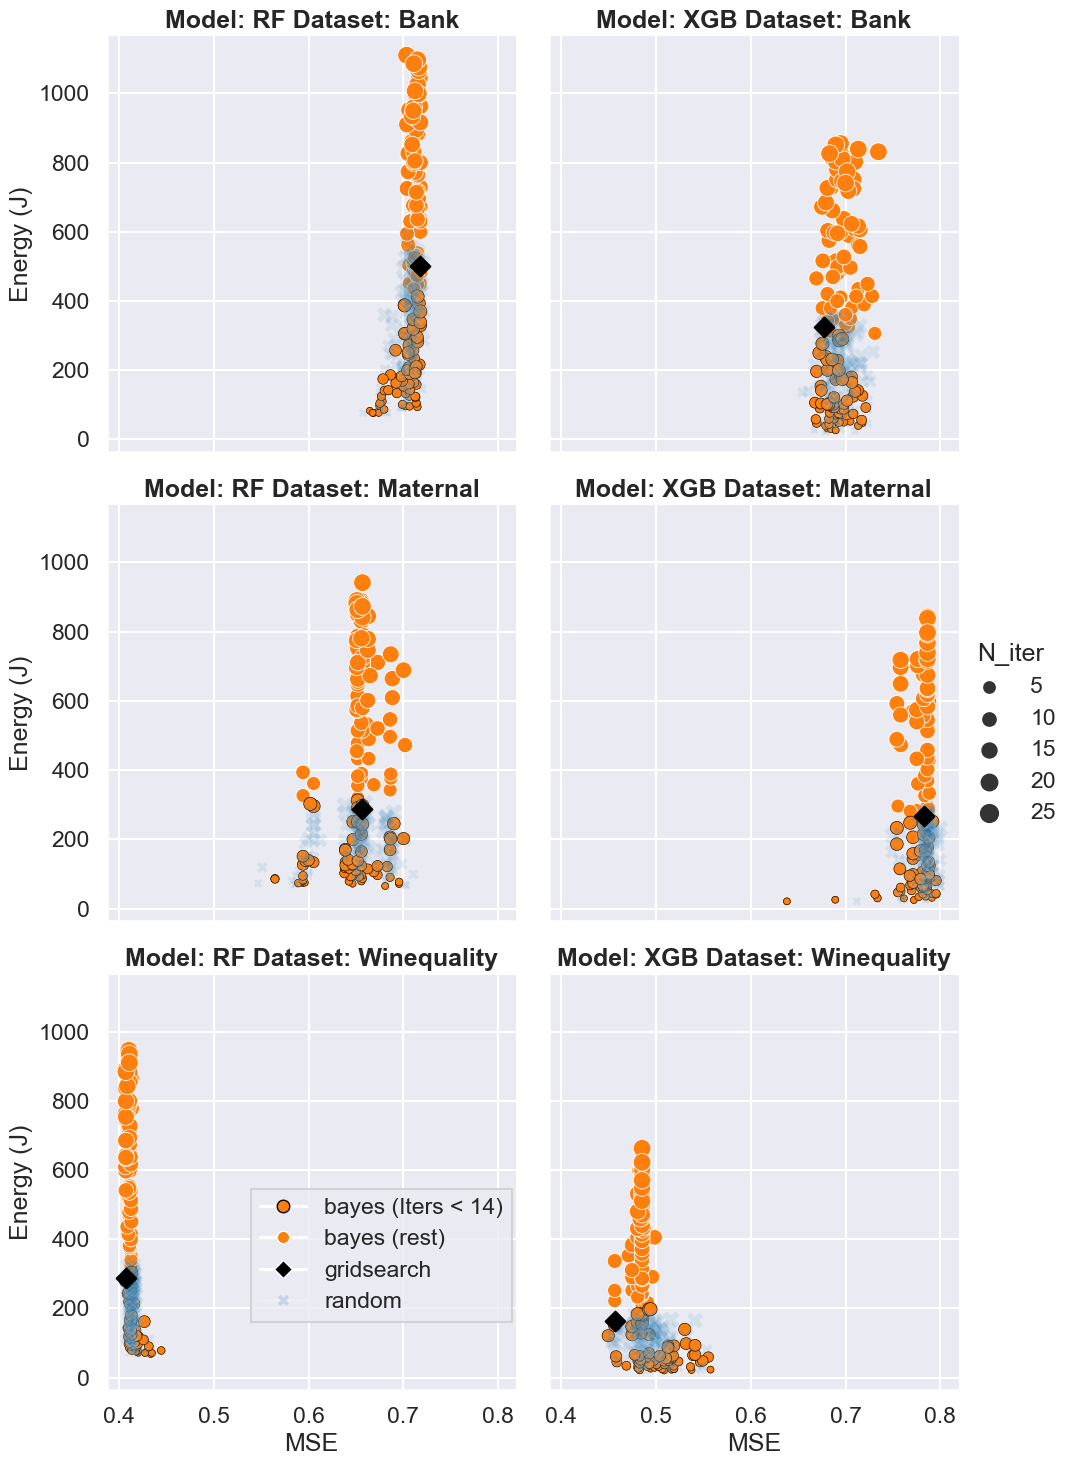

In [145]:
# plot pareto for energy vs. f1 performance
data = results[results.Tuner == 'bayes']
# target val on x axis to match Donald plots
grid = sns.relplot(data=data, y='Energy (J)', x='target_val', col="model",
                   row="dataset", size='N_iter', color='tab:orange',
                   markers={'random': 'X', 'bayes': 'o', 'grid': 'D'})

for (dataset, model), ax in grid.axes_dict.items():
    # highlight bayes runs with less than 14 iterations
    select = (data.N_iter < 14) & (data.model == model) & (data.dataset == dataset)
    pp = sns.scatterplot(data=data[select], y='Energy (J)', x='target_val',
                         marker='o', color='tab:orange', size='N_iter',
                         sizes=(25, 90),
                         edgecolor='black', legend=None, ax=ax)
    # plot random manually
    randomtuner = results[(results.Tuner == 'random') & (results.model == model) & \
                          (results.dataset == dataset)]
    p = sns.scatterplot(data=randomtuner, y='Energy (J)', x='target_val', marker='X',
                        color='tab:blue', alpha=0.1, size='N_iter', ax=ax, legend=None)
    # plot grid search manually
    gridpoint = gridresults[(gridresults.model == model) & (gridresults.dataset == dataset)]
    gg = addgridpoint(gridpoint, ax, 'target_val', 'Energy (J)')

    # set subplot title to match project convention
    ax.set_title('Model: {0} Dataset: {1}'.format(model.upper(),
                                                  dataset.capitalize()), weight='bold')
    # dirty way to set x axis labels
    if dataset == 'maternal':
        ax.set_xlabel('F1 Score')

# set x axis lables
grid.axes[2, 0].set_xlabel('MSE')
grid.axes[2, 1].set_xlabel('MSE')
    
# create proxy artists for legend
from matplotlib import lines as mlines
orangecircle = mlines.Line2D([], [], marker='o', color='w',
                             markerfacecolor='tab:orange',
                             markeredgecolor='black')
orangecircle_noborder = mlines.Line2D([], [], marker='o', color='w',
                             markerfacecolor='tab:orange')
bluecross = mlines.Line2D([], [], marker='X', color='w',
                             markerfacecolor='tab:blue',
                             alpha=0.2)
blackdiamond = mlines.Line2D([], [], marker='D', color='w',
                             markerfacecolor='black')
plt.gcf().legend(handles=[orangecircle, orangecircle_noborder, blackdiamond, bluecross],
                 labels=['bayes (Iters < 14)', 'bayes (rest)', 'gridsearch', 'random'],
                 fancybox=False,
                 edgecolor=None, loc='lower right', bbox_to_anchor=(0.5, 0.1))

# TODO: set x label
#grid.set(xaxislabels='F1 | MSE (winequality)')
plt.savefig('figures/tuning_earlystopping_pareto_talk.pdf')

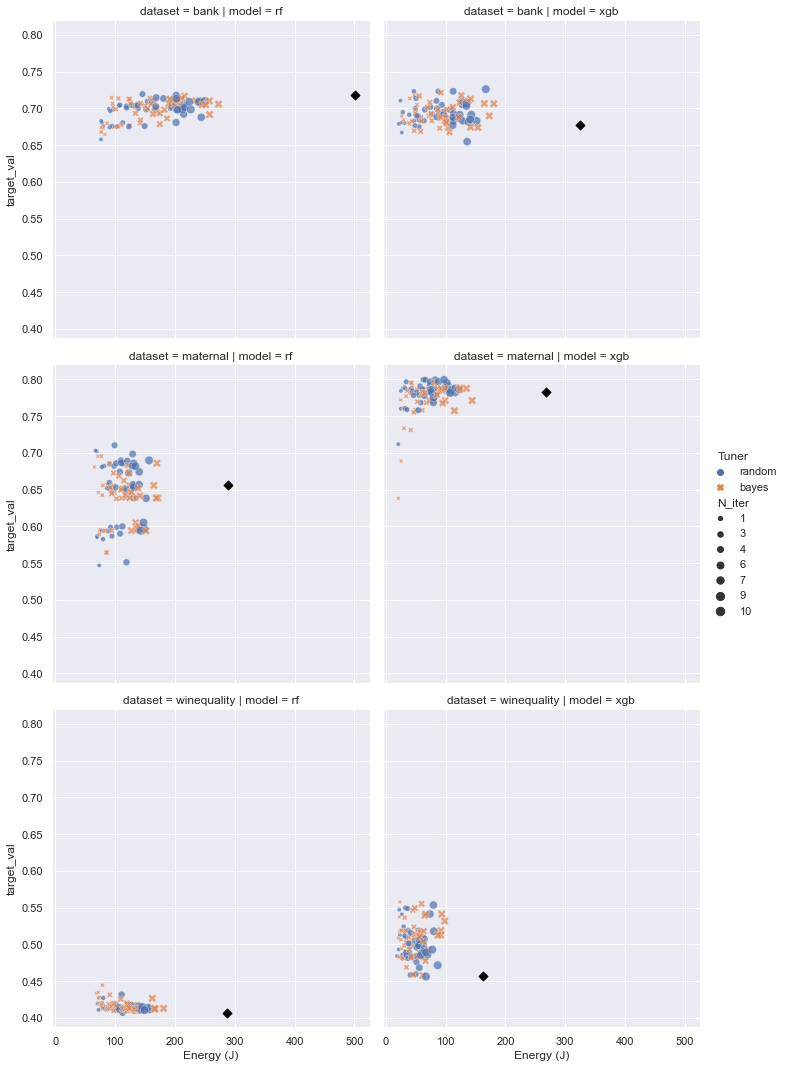

In [73]:
# plot pareto for energy vs. f1 performance with just few iterations
data = results[results.N_iter < 11]
grid = sns.relplot(data=data, x='Energy (J)', y='target_val', col="model", row="dataset",
                   hue="Tuner", style='Tuner', size='N_iter', alpha=0.7)

for (dataset, model), ax in grid.axes_dict.items():
    gridpoint = gridresults[(gridresults.model == model) & (gridresults.dataset == dataset)]
    addgridpoint(gridpoint, ax, 'Energy (J)', 'target_val')

#sns.set(yaxislabel='F1 | MSE (winequality)')
plt.savefig('figures/tuning_earlystopping_pareto.pdf')

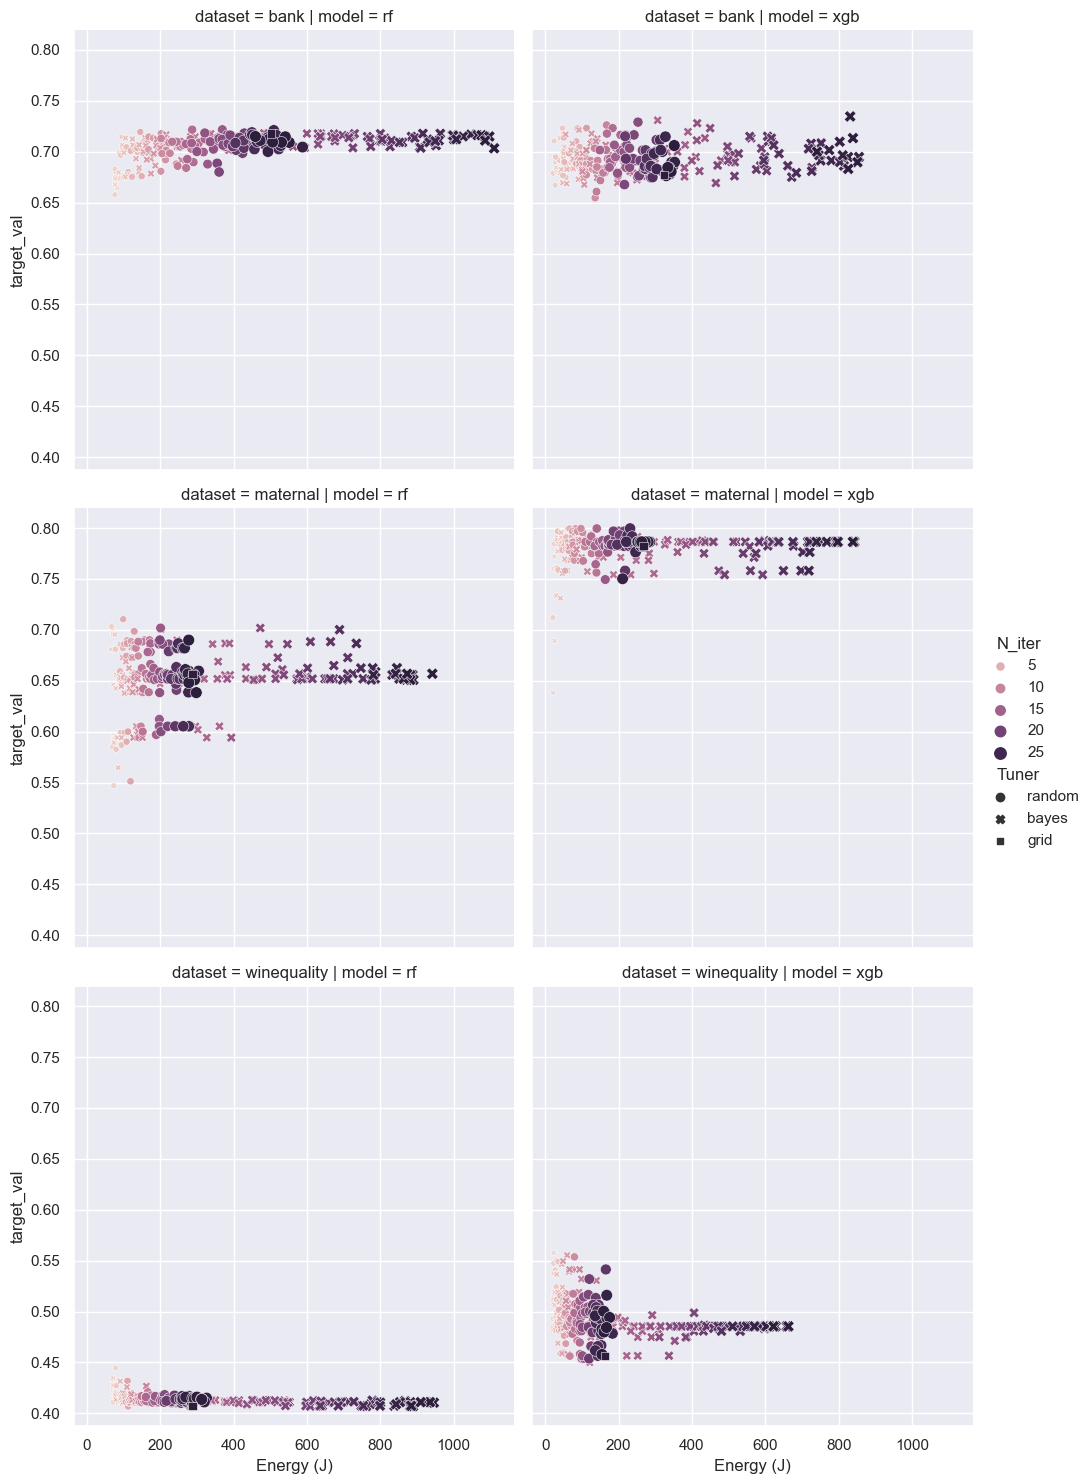

In [35]:
# Trying some things to make relationship with N_iters more clear
sns.relplot(data=results, x='Energy (J)', y='target_val', col="model", row="dataset",
            hue="N_iter", style="Tuner", size="N_iter")
#sns.set(yaxislabel='F1 | MSE (winequality)')


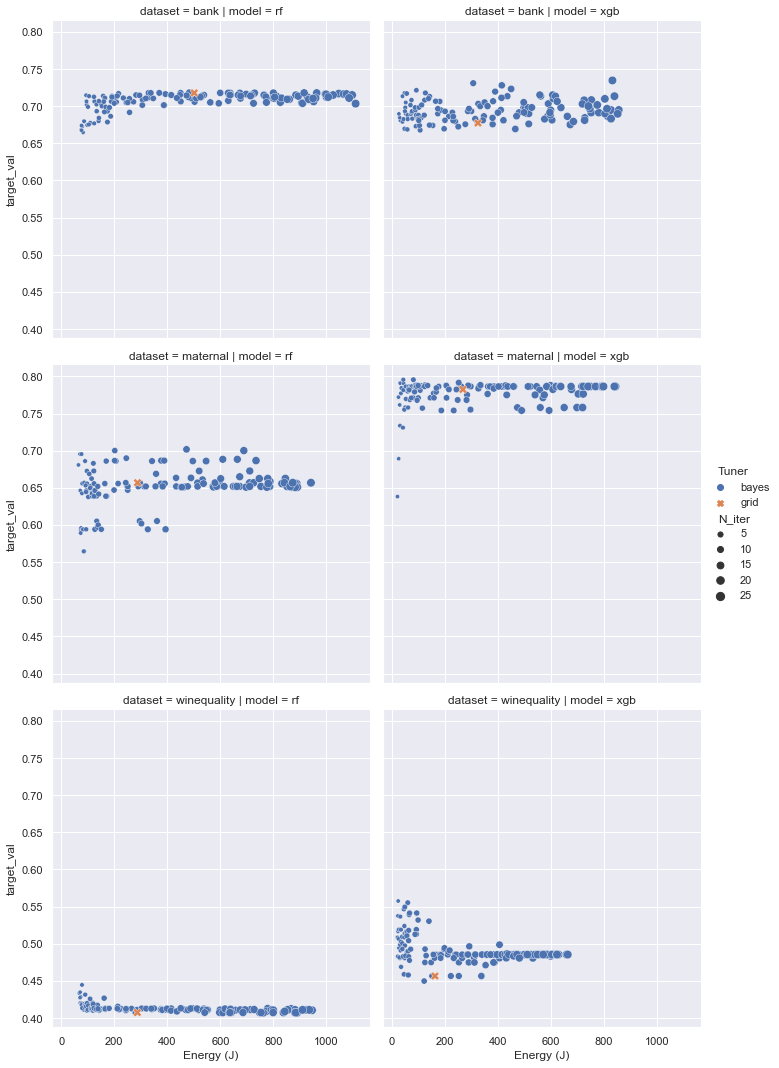

In [12]:
# try f1 vs. energy pareto for without random
# TODO: match tuner hue/marker style across plots
data = results[results.Tuner != 'random']
sns.relplot(data=data, x='Energy (J)', y='target_val', col="model", row="dataset",
            hue="Tuner", style='Tuner', size='N_iter')
#sns.set(yaxislabel='F1 | MSE (winequality)')
plt.savefig('figures/tuning_earlystopping_pareto_norandom.pdf')

In [13]:
# in above differences are a little hard to see because of scaled y-axes...
# try separate plots for each dataset
def plot_tuning_pareto_dataset(dataset: str,
                               allresults: pd.DataFrame) -> sns.axisgrid.FacetGrid:
    data = results[results.dataset == dataset]
    grid = sns.relplot(data=data, x='Energy (J)', y='target_val', hue='Tuner',
                       style='Tuner', size='N_iter', col='model')
    grid.set(ylabel=data.Target.iloc[0])
    return grid

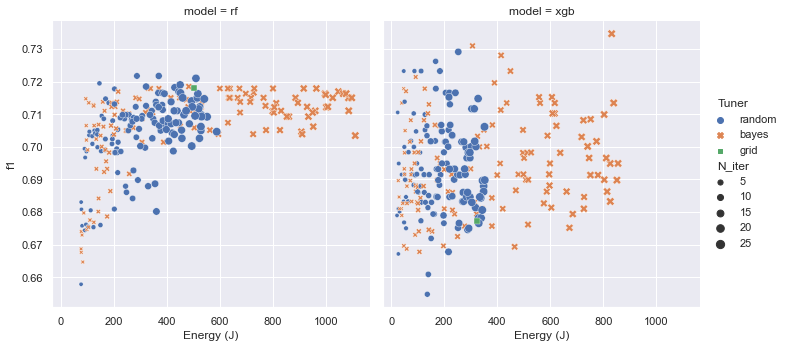

In [14]:
grid = plot_tuning_pareto_dataset('bank', results)
plt.savefig('figures/tuning_earlystopping_pareto_bank.pdf')

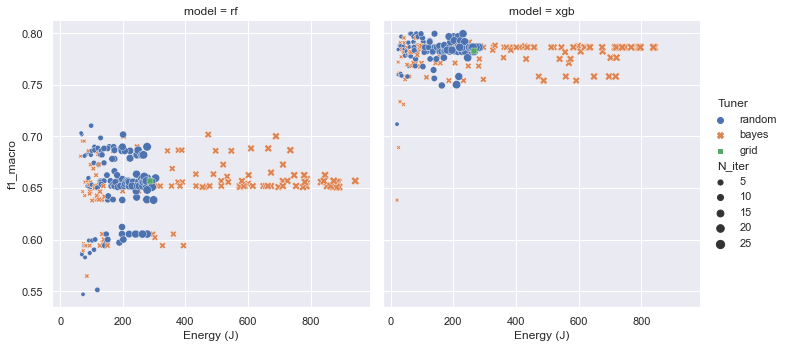

In [15]:
grid = plot_tuning_pareto_dataset('maternal', results)
plt.savefig('figures/tuning_earlystopping_pareto_maternal.pdf')

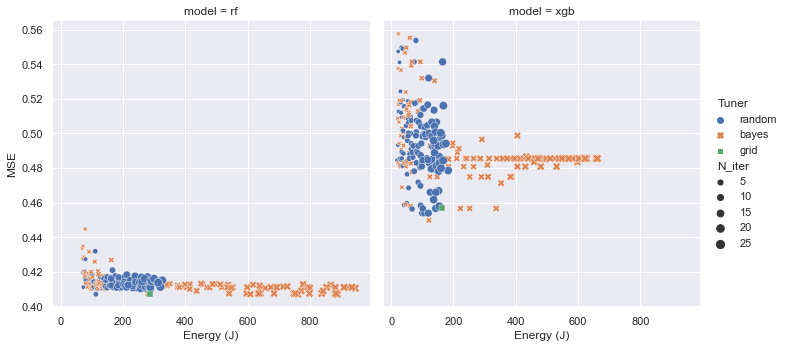

In [16]:
grid = plot_tuning_pareto_dataset('winequality', results)
plt.savefig('figures/tuning_earlystopping_pareto_winequality.pdf')